In [1]:
from token_shap import TokenSHAP

In [2]:
model_name = "llama3"
tokenizer_path ="NousResearch/Hermes-2-Theta-Llama-3-8B"
tshap = TokenSHAP(model_name, tokenizer_path)

/opt/anaconda3/envs/opensora/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


How will deep learning impact future?
0.8
0.6
0.4
0.0
What are issues in healthcare?
0.8
0.6
0.4
0.2
0.0
How can ML improve cybersecurity?
0.8
0.6
0.4
0.2
0.0
What is AI's impact on education?
0.8
0.6
0.4
0.2
0.0
How is AI affecting autonomous vehicles?
0.8
0.6
0.4
0.2
0.0
What are AI's environmental benefits?
0.8
0.6
0.4
0.2
0.0
How can AI aid personalized medicine?
0.8
0.6
0.4
0.2
0.0
What are AI challenges in finance?
0.8
0.6
0.4
0.2
0.0
How does AI influence marketing?
0.8
0.6
0.4
0.2
0.0
What are AI's prospects in robotics?
0.8
0.6
0.4
0.2
0.0


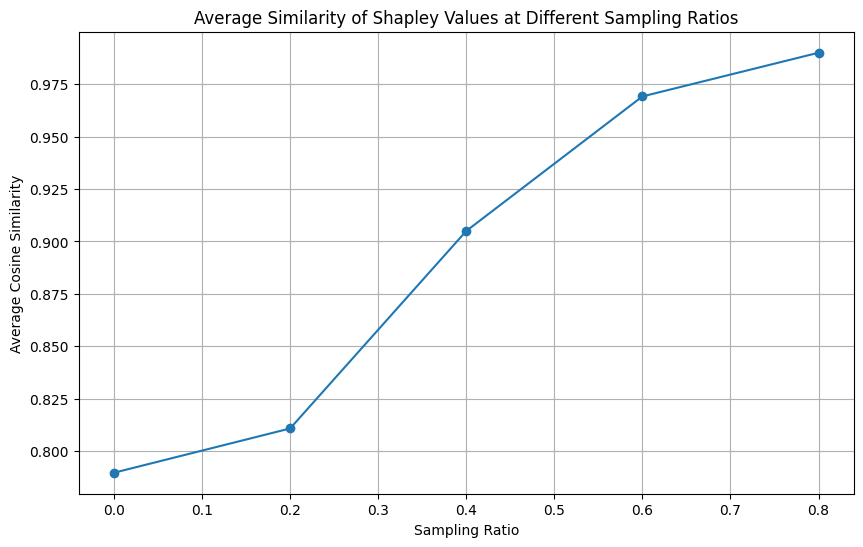

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import json
import os

# Initialize lists to store results
sampling_ratios = [0.8, 0.6, 0.4, 0.2, 0.0]
num_questions = 10
similarities = {ratio: [] for ratio in sampling_ratios}

# Define the questions
questions = [
    "How will deep learning impact future?",
    "What are issues in healthcare?",
    "How can ML improve cybersecurity?",
    "What is AI's impact on education?",
    "How is AI affecting autonomous vehicles?",
    "What are AI's environmental benefits?",
    "How can AI aid personalized medicine?",
    "What are AI challenges in finance?",
    "How does AI influence marketing?",
    "What are AI's prospects in robotics?"
]

def shapley_dict_to_vector(shapley_dict):
    return np.array(list(shapley_dict.values()))

output_file = 'similarity_results.json'
if os.path.exists(output_file):
    with open(output_file, 'r') as f:
        similarities = json.load(f)
else:
    similarities = {ratio: [] for ratio in sampling_ratios}

for question in questions:
    print(question)
    # Calculate baseline Shapley values
    baseline_shap = tshap.analyze(question, sampling_ratio=1.0, splitter=' ')
    baseline_shap_values = shapley_dict_to_vector(tshap.shapley_values)
    
    for ratio in sampling_ratios:
        print(ratio)
        # Calculate Shapley values for the given sampling ratio
        sampled_shap = tshap.analyze(question, sampling_ratio=ratio, splitter=' ')
        sampled_shap_values = shapley_dict_to_vector(tshap.shapley_values)
        
        # Calculate similarity between baseline and sampled Shapley values
        similarity = cosine_similarity(
            [baseline_shap_values], 
            [sampled_shap_values]
        )[0, 0]
        
        # Store the similarity
        similarities[ratio].append(similarity)
        
        # Save the results to disk
        with open(output_file, 'w') as f:
            json.dump(similarities, f)

# Calculate average similarities for each sampling ratio
average_similarities = {ratio: np.mean(similarities[ratio]) for ratio in sampling_ratios}

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sampling_ratios, [average_similarities[ratio] for ratio in sampling_ratios], marker='o')
plt.xlabel('Sampling Ratio')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Similarity of Shapley Values at Different Sampling Ratios')
plt.grid(True)
plt.show()

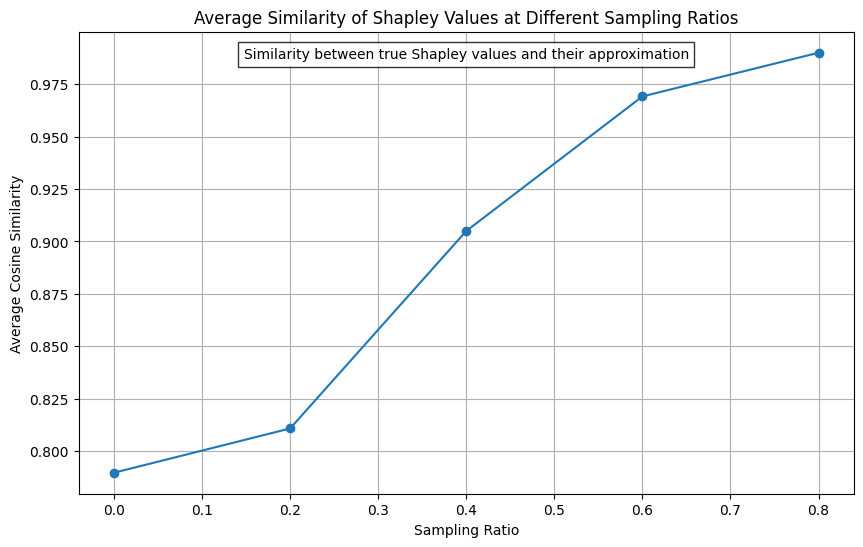

In [6]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sampling_ratios, [average_similarities[ratio] for ratio in sampling_ratios], marker='o')
plt.xlabel('Sampling Ratio')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Similarity of Shapley Values at Different Sampling Ratios')
plt.text(0.5, 0.95, 'Similarity between true Shapley values and their approximation', 
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.grid(True)

# Save the plot
plot_file = 'average_similarity_plot.png'
plt.savefig(plot_file)

# Show the plot
plt.show()